In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
V_in, V_out, *_ = np.loadtxt('../data/run3.tsv', delimiter='\t', unpack=True)
gain = 10
I_out = V_out / (10 * gain)

In [3]:
values, counts = np.unique_counts(V_in)

V_in_combined = np.zeros_like(values)
I_out_combined = np.zeros_like(values)
I_out_std_combined = np.zeros_like(values)
for i, (value, count) in enumerate(zip(values, counts)):
    idx = np.nonzero(V_in == value)
    V_in_combined[i] = value
    I_out_combined[i] = np.mean(I_out[idx])
    I_out_std_combined[i] = np.std(I_out[idx])

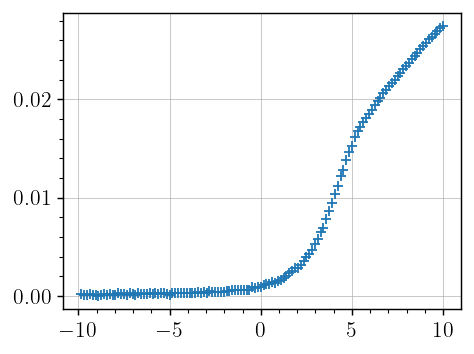

In [4]:
# plt.scatter(V_in, I_out)
plt.scatter(V_in_combined, (I_out_combined))
idx = I_out_combined < 0
plt.scatter(V_in_combined[idx], I_out_combined[idx])

## Find V_p, ln(I_p)

T_e = np.float64(20308.95197711581), INCOHERENT: T = np.float64(2.803953423825297e-19), n_e = 1.59270578838892e+17+/-24477924.893448677


(np.float64(20308.95197711581),
 np.float64(2.803953423825297e-19),
 1.59270578838892e+17+/-24477924.893448677)

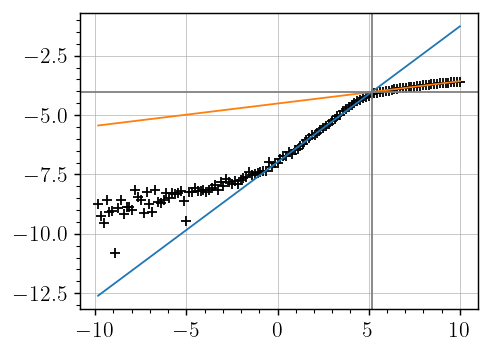

In [7]:
idx_B = np.logical_and(0 < V_in_combined, V_in_combined < 3)
idx_C = V_in_combined > 6

coefsB, covB = np.polyfit(V_in_combined[idx_B], np.log(I_out_combined[idx_B]), 1, cov=True)
fitfuncB = np.poly1d(coefsB)
coefsC, covC = np.polyfit(V_in_combined[idx_C], np.log(I_out_combined[idx_C]), 1, cov=True)
fitfuncC = np.poly1d(coefsC)

plt.scatter(V_in_combined, np.log(I_out_combined), c='k')
x = np.linspace(V_in_combined[0], V_in_combined[-1])
plt.plot(x, fitfuncB(x))
plt.plot(x, fitfuncC(x))

V_sp_intersect = -(coefsC[1] - coefsB[1]) / (coefsC[0] - coefsB[0])
I_sp_intersect = np.exp(fitfuncB(V_sp_intersect))
plt.axvline(V_sp_intersect)
plt.axhline(np.log(I_sp_intersect))

T_e = 1/coefsB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT  # why not???? * ELEMENTARY_CHARGE
T = T_e * BOLTZMANN_CONSTANT

n_e = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT * T_e)) * I_sp_intersect

print(f"{T_e = }, INCOHERENT: {T = }, {n_e = }")
T_e, T, n_e